# Agriculture Prices

In [98]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
import statsmodels.api as sm

In [87]:
corn = yf.Ticker('ZCH25.CBT')
df_corn = corn.history(period = 'max')
df_corn

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-14 00:00:00-05:00,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15 00:00:00-05:00,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16 00:00:00-05:00,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19 00:00:00-05:00,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20 00:00:00-05:00,570.00,570.00,565.50,565.50,1,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-03 00:00:00-05:00,476.75,491.00,472.50,488.75,322166,0.0,0.0
2025-02-04 00:00:00-05:00,488.00,497.25,487.25,494.50,279780,0.0,0.0
2025-02-05 00:00:00-05:00,494.00,498.50,489.75,493.25,226004,0.0,0.0


In [88]:
wheat = yf.Ticker('KE=F') # KEH25, KE=F
df_wheat = wheat.history(period='max')

In [89]:
# a baseline for predicting volatility
"""
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
"""

""" def volatilities(df, metric, n):

    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.var(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.var(df[(n-1)*interval:n*interval][metric]))
    return sigmas """

def volatilities(df, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.std(df[i-n:i]['Close']))
    sigmas = np.insert(sigmas, 0, np.full((n), 0))
    return sigmas


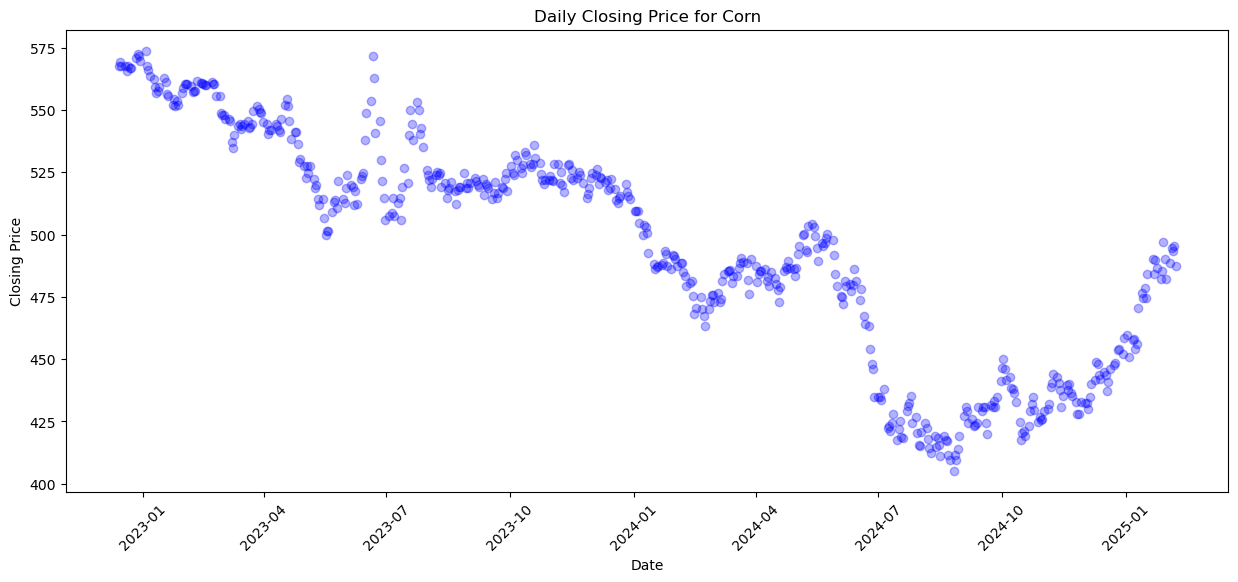

In [96]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_corn.index, df_corn['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Corn')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [91]:
rolling_sigmas_corn = volatilities(df_corn,n=30)

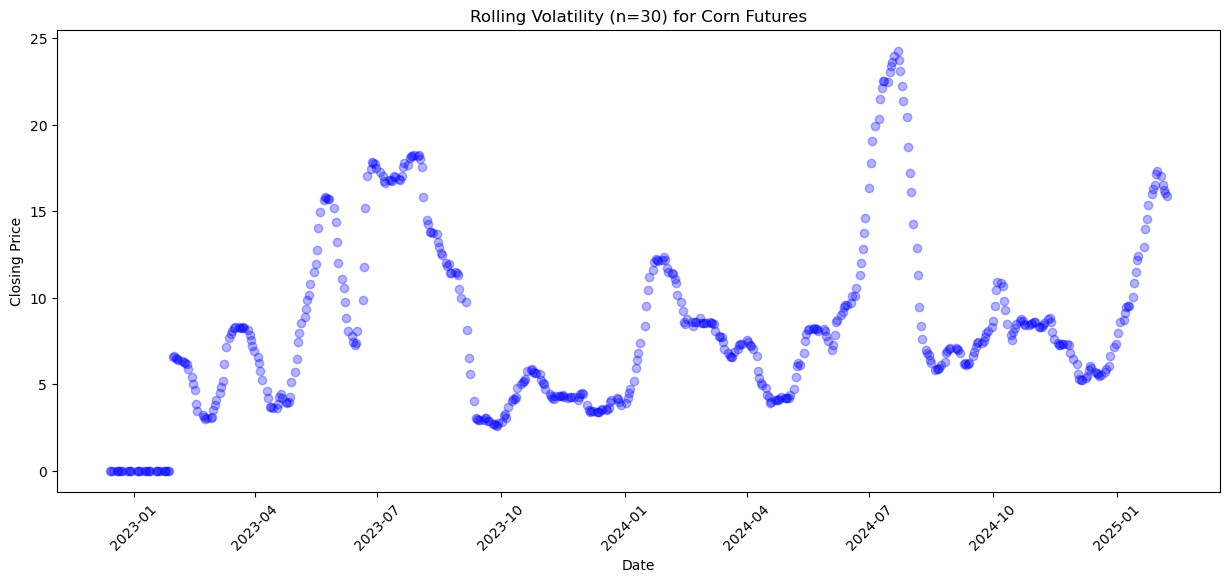

In [92]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_corn.index, rolling_sigmas_corn, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=30) for Corn Futures')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

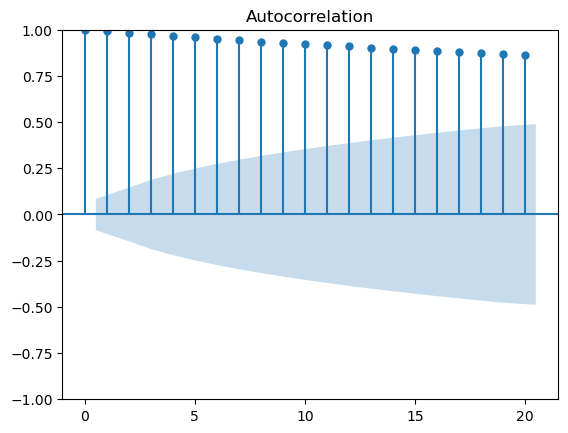

In [ ]:
sm.graphics.tsa.plot_acf(df_corn['Close'], lags = 20) # correlation between X and a delayed copy of itself, up to 20 lages
plt.show()

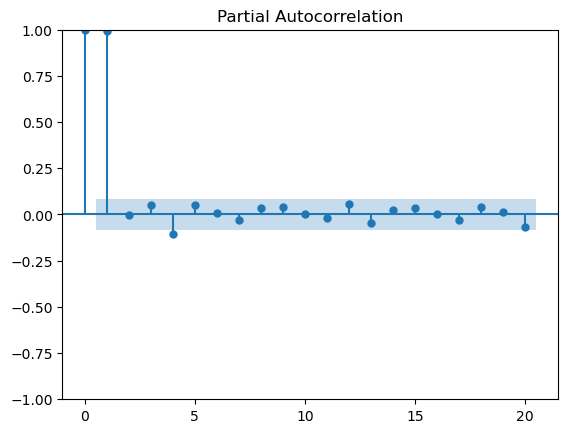

In [101]:
# Partial autocorrelation is a statistical measure in time series analysis that represents the correlation between an observation 
# and its lagged values, while accounting for the influence of all the intervening lags, essentially isolating the direct 
# relationship between two points in time without the effect of other intermediary observations

sm.graphics.tsa.plot_pacf(df_corn['Close'], lags = 20)
plt.show()

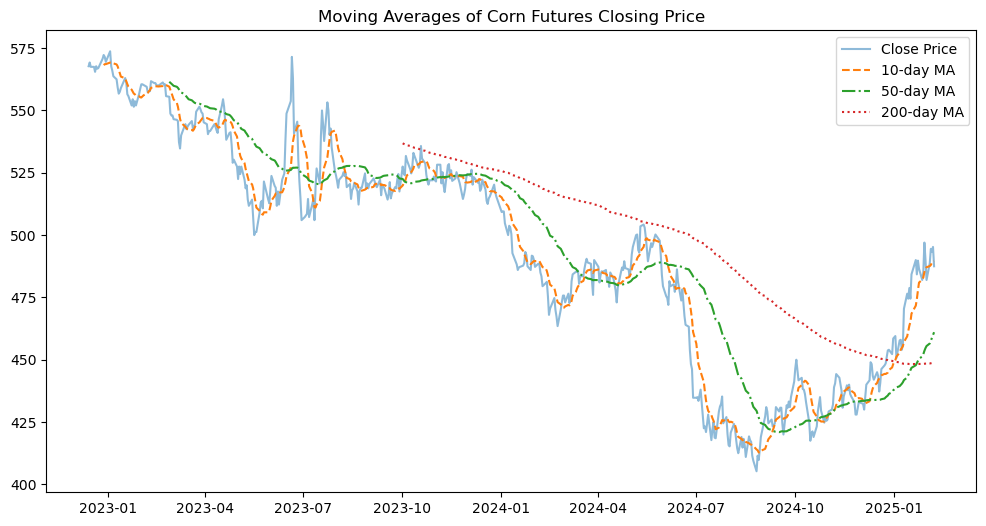

In [105]:
# Moving Averages
df_corn["MA_10"] = df_corn["Close"].rolling(window=10).mean()
df_corn["MA_50"] = df_corn["Close"].rolling(window=50).mean()
df_corn["MA_200"] = df_corn["Close"].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_corn["Close"], label="Close Price", alpha=0.5)
plt.plot(df_corn["MA_10"], label="10-day MA", linestyle="--")
plt.plot(df_corn["MA_50"], label="50-day MA", linestyle="-.")
plt.plot(df_corn["MA_200"], label="200-day MA", linestyle=":")
plt.legend()
plt.title("Moving Averages of Corn Futures Closing Price")
plt.show()

In [107]:
# for seasonal decomposition
from statsmodels.tsa.seasonal import STL

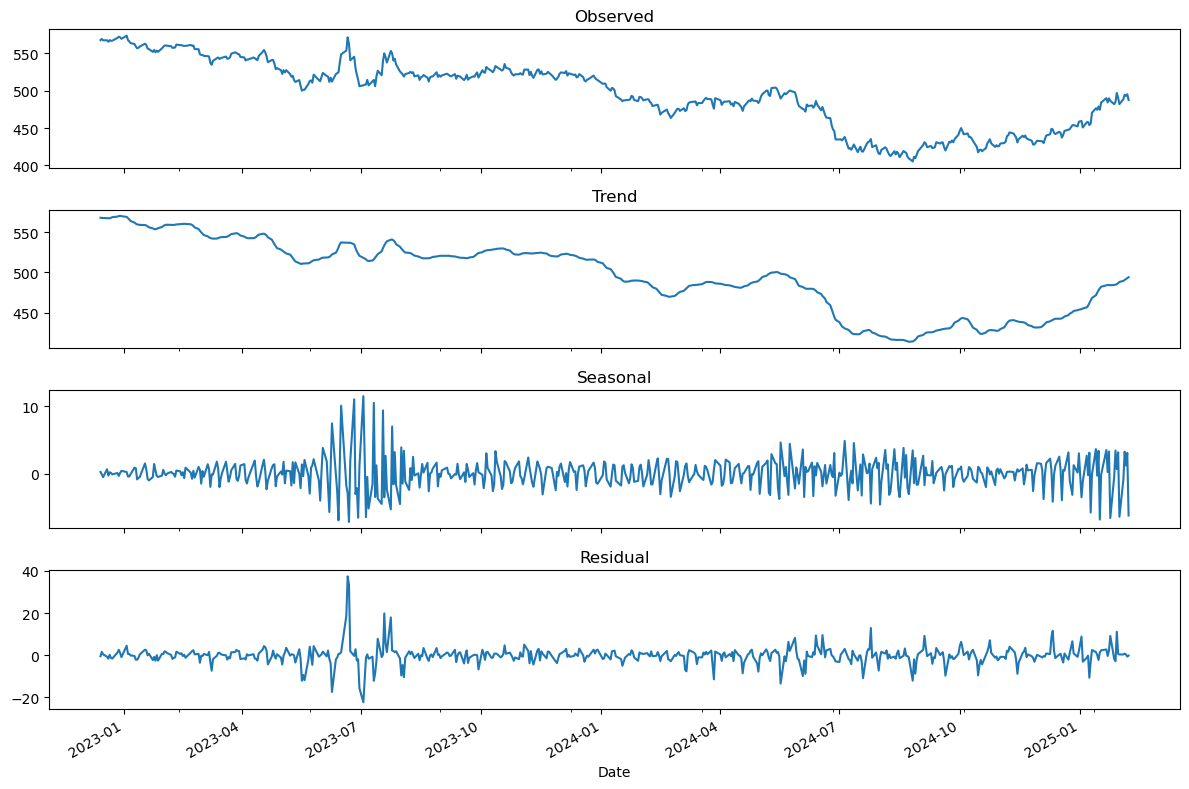

In [114]:
# Seasonal Decomposition (Using STL)
stl = STL(df_corn["Close"], period=5,robust=True)  # 5 day period (since weekends are excluded)
res = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res.observed.plot(ax=axes[0], title="Observed") # original prices
res.trend.plot(ax=axes[1], title="Trend") # smooths out short term fluctuations to find long-term movement
res.seasonal.plot(ax=axes[2], title="Seasonal") # tries to find repeating patterns
res.resid.plot(ax=axes[3], title="Residual") # what remains after removing trend and seaonality
plt.tight_layout()
plt.show()


# Wheat

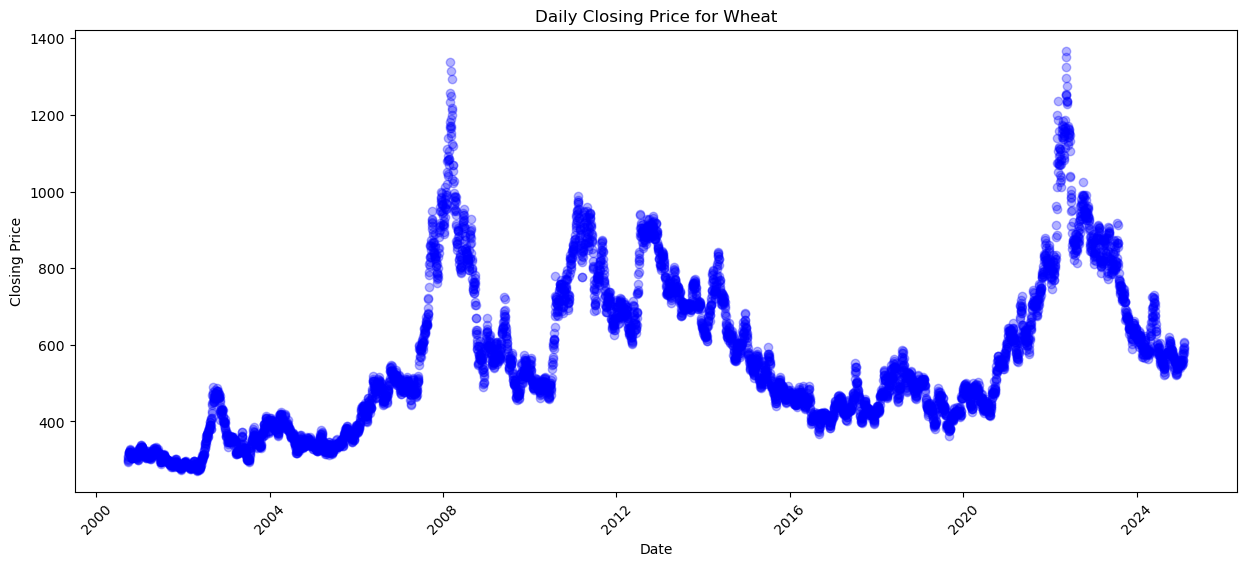

In [97]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_wheat.index, df_wheat['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Wheat')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [94]:
rolling_sigmas_wheat = volatilities(df_wheat,n=365)

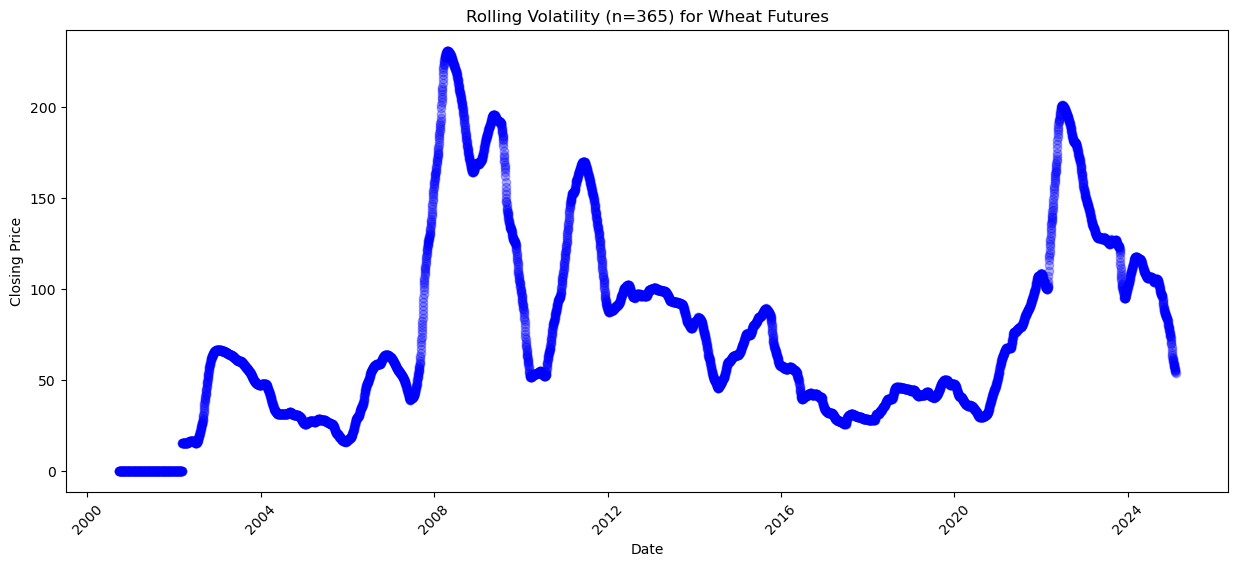

In [95]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_wheat.index, rolling_sigmas_wheat, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=365) for Wheat Futures')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

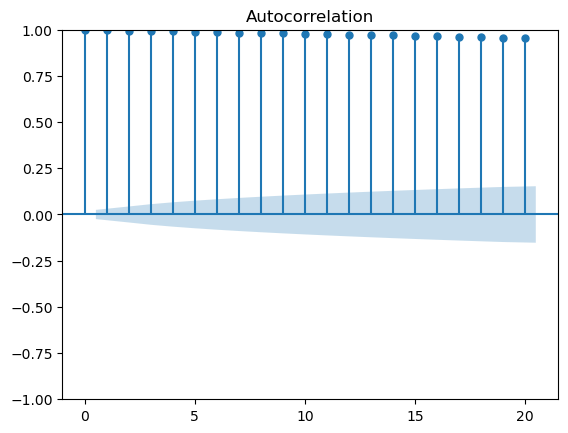

In [102]:
sm.graphics.tsa.plot_acf(df_wheat['Close'], lags = 20)
plt.show()

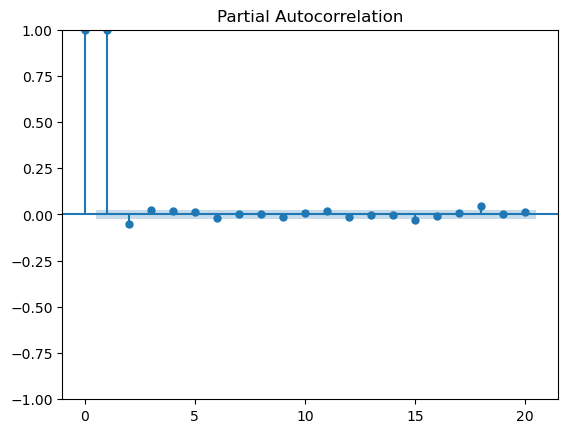

In [103]:
sm.graphics.tsa.plot_pacf(df_wheat['Close'], lags = 20)
plt.show()

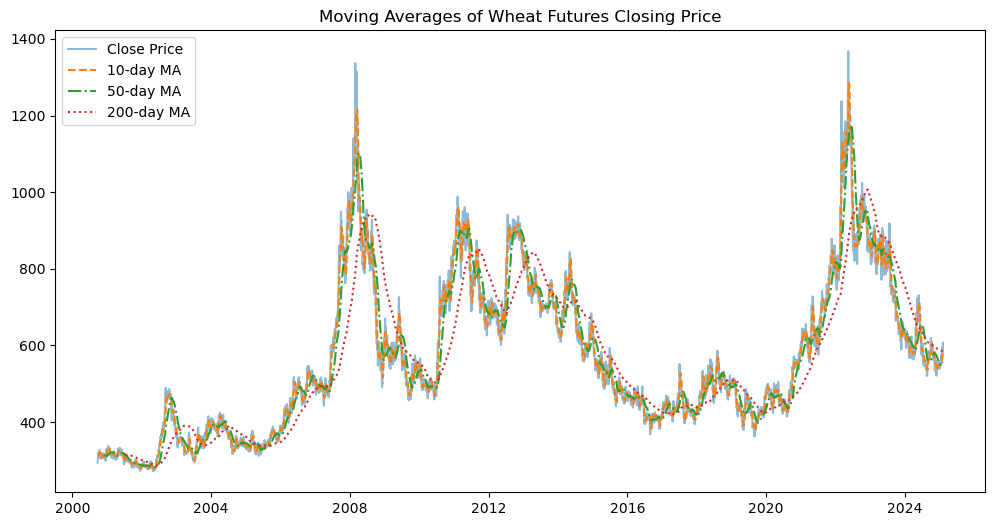

In [116]:
# Moving Averages
df_wheat["MA_10"] = df_wheat["Close"].rolling(window=10).mean()
df_wheat["MA_50"] = df_wheat["Close"].rolling(window=50).mean()
df_wheat["MA_200"] = df_wheat["Close"].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_wheat["Close"], label="Close Price", alpha=0.5)
plt.plot(df_wheat["MA_10"], label="10-day MA", linestyle="--")
plt.plot(df_wheat["MA_50"], label="50-day MA", linestyle="-.")
plt.plot(df_wheat["MA_200"], label="200-day MA", linestyle=":")
plt.legend()
plt.title("Moving Averages of Wheat Futures Closing Price")
plt.show()

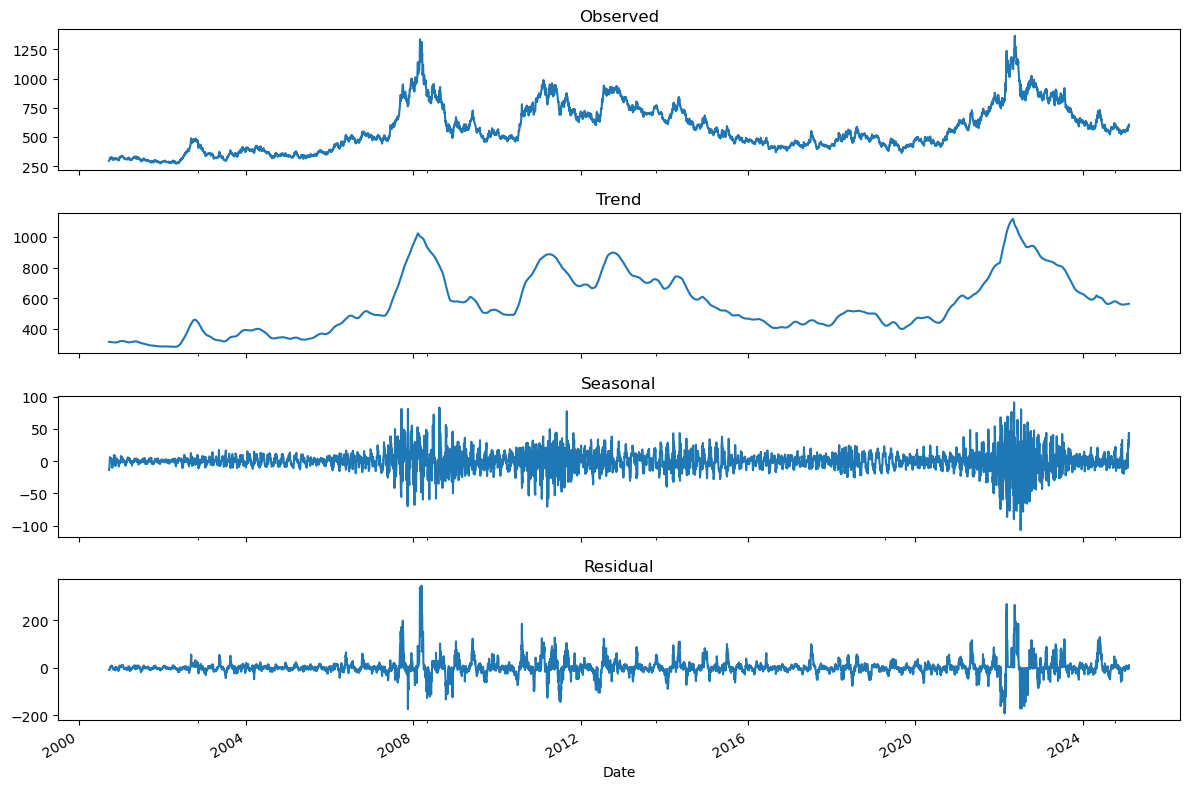

In [119]:
# Seasonal Decomposition (Using STL)
stl = STL(df_wheat["Close"], period=40,robust=True)  # 40 day period
res = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res.observed.plot(ax=axes[0], title="Observed") # original prices
res.trend.plot(ax=axes[1], title="Trend") # smooths out short term fluctuations to find long-term movement
res.seasonal.plot(ax=axes[2], title="Seasonal") # tries to find repeating patterns
res.resid.plot(ax=axes[3], title="Residual") # what remains after removing trend and seaonality
plt.tight_layout()
plt.show()